In [7]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import glob
from matplotlib.ticker import MultipleLocator
import subprocess


In [8]:
setup_path ="/home/haue/repositories/Masters/setup/" 
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/inclbetacut/"
twop_path = "/home/haue/repositories/Masters/data/twoproton/Al/"
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
twop_files = glob.glob(os.path.join(twop_path, "*mlio.root"))


In [9]:
Elin = np.arange(0., 11000., 10.)
sac = np.array([])
for dssd, ssd, cutoff, thresh in zip(
    ["U1", "U2", "U3", "U4", "U6"], ["P1", "P2", "P3", "P4", "P6"], [600, 500, 260, 1000, 300], [280, 340, 180, 350, 220]): # P6 thresh: 220
    filename = "sam_21al_%s.dat" % dssd
    if not os.path.exists(filename):
        f = open(filename, "w")
        subprocess.call(["SAM", "-i45", "-d%s" % dssd], cwd="/home/haue/repositories/Masters/setup", stdout=f)
        f.close()
    sr = np.loadtxt(filename)
    #im = plt.imshow(100*np.transpose(sr)/(4*np.pi), extent=[0.5, 16.5, 16.5, 0.5], vmin=0., cmap=plt.cm.inferno)
    #cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    #plt.show()
    
    filename = "tdz_21al_%s.dat" % dssd
    if not os.path.exists(filename):
        f = open(filename, "w")
        subprocess.call(["TDZ", "-d%s,%s" % (dssd, ssd), "-i45", "--threshold=%s" % str(thresh)], cwd="/home/haue/repositories/Masters/setup/", stdout=f)
        f.close()
    
    v, fEdepmax, Elow, Eupp, fEdeplow, Esplow = np.loadtxt(filename, unpack=True)
    for i in range(len(Elin)):
        val = 0.
        if Elin[i] < cutoff:
#             print(Elin[i])
            sac = np.append(sac, val)
        else:
            # do not include outermost strips
            for j in range(0+1, 16-1):
                for k in range(0+1, 16-1):
                    if Esplow[j*16 + k] < Elin[i] and Elin[i] < Eupp[j*16 + k]:
#                         print(j, k, Elin[i])
                        pass
                    else:
                        val += sr[j, k]
            sac = np.append(sac, val)

(4.423426704849798,
 4.993289447838043,
 3.872740098353509,
 3.326542500626603,
 34.06124226014354,
 6.795917343263473)

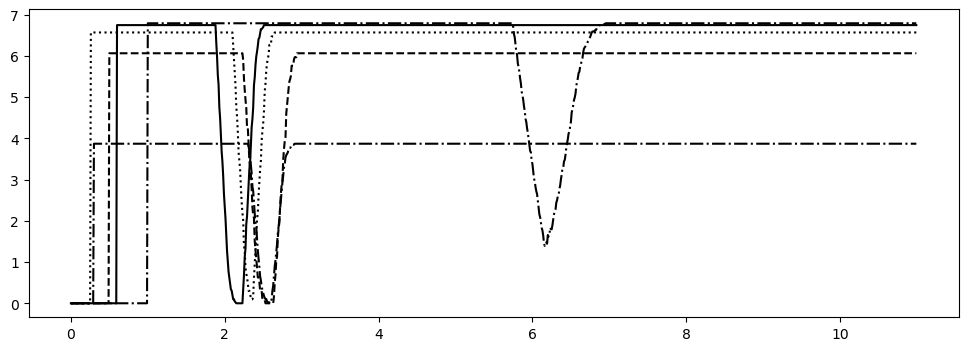

In [10]:
sac_ = 100*sac/(4*np.pi)
sac1 = sac_[0:len(Elin)]
sac2 = sac_[len(Elin):2*len(Elin)]
sac3 = sac_[2*len(Elin):3*len(Elin)]
sac4 = sac_[3*len(Elin):4*len(Elin)]
sac6 = sac_[4*len(Elin):5*len(Elin)]
plt.figure(figsize=(12,4))
plt.plot(Elin/1e3, sac1, 'k-', label='U1-P1')
plt.plot(Elin/1e3, sac2, 'k--', label='U2-P2')
plt.plot(Elin/1e3, sac3, 'k:', label='U3-P3')
plt.plot(Elin/1e3, sac4, 'k-.', label='U4-P4')
plt.plot(Elin/1e3, sac6, 'k-.', label='U6-P6')
res = ((np.max(sac1)+np.max(sac2)+np.max(sac3)+np.max(sac4)+np.max(sac6)))
scale=100/res
res/np.max(sac4), (res+np.max(sac6))/np.max(sac4), np.max(sac6), scale, res+4, np.max(sac4)

In [76]:
E = np.array([])
for batch in uproot.iterate(Al_files, expressions=["E"],
                            cut="(id==3) & (mul==1)"):
    E=np.append(E, ak.flatten(batch.E))
E2 = np.array([])
for batch in uproot.iterate(Al_files, expressions=["E"],
                            cut="(id==3)"):
    E2=np.append(E2, ak.flatten(batch.E))
    
E2p = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E"],
                            cut="(id==3)"):
    E2p=np.append(E2p, ak.flatten(batch.E))
len(E), len(E2)    

(31513, 33184)

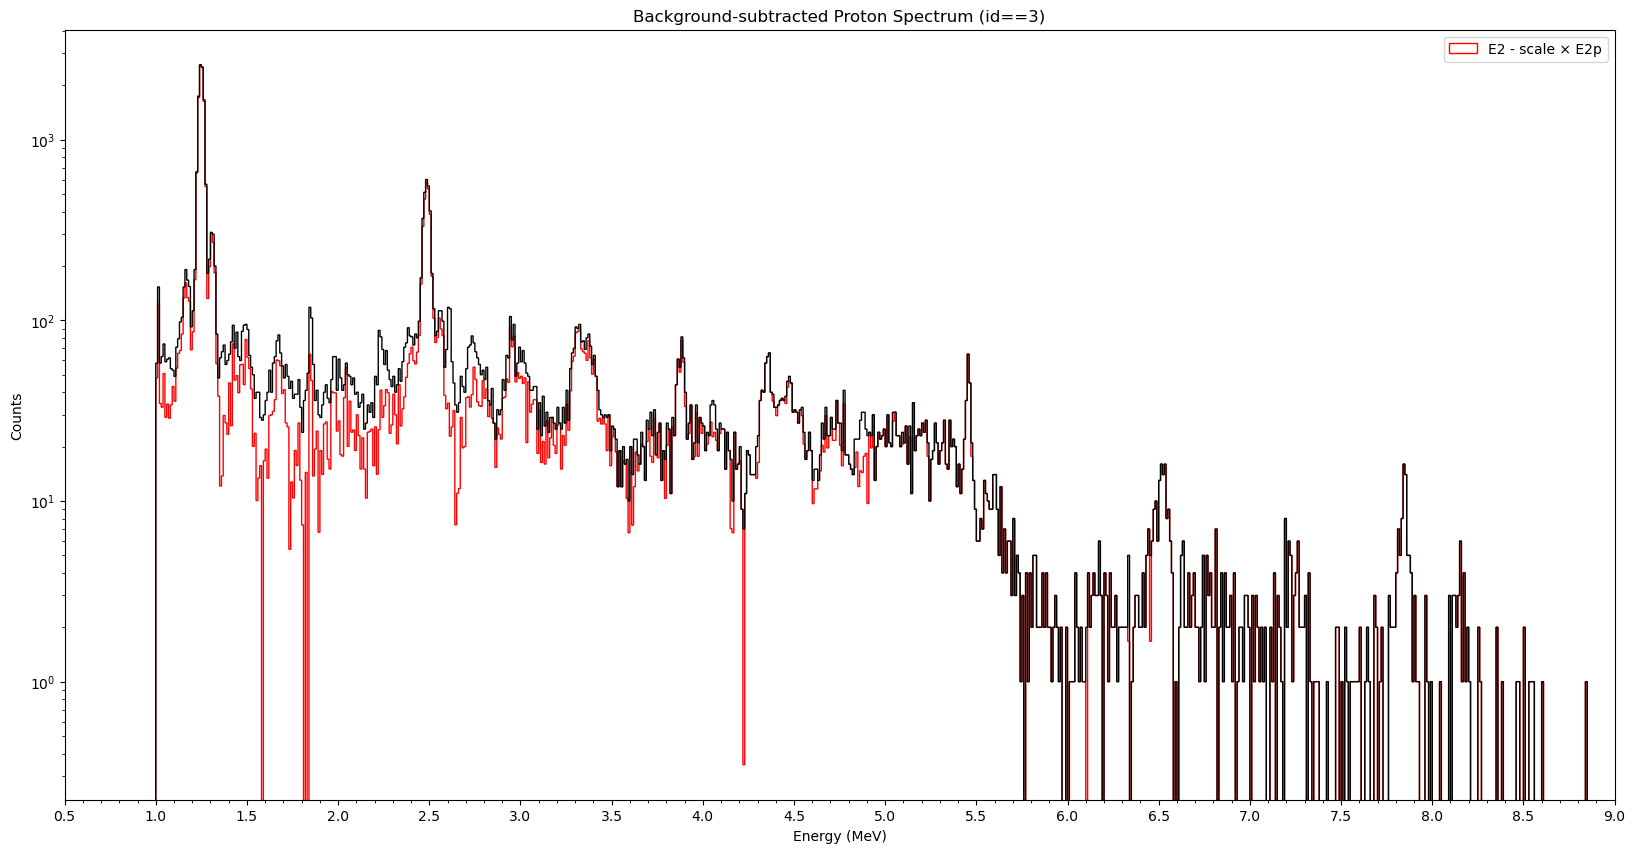

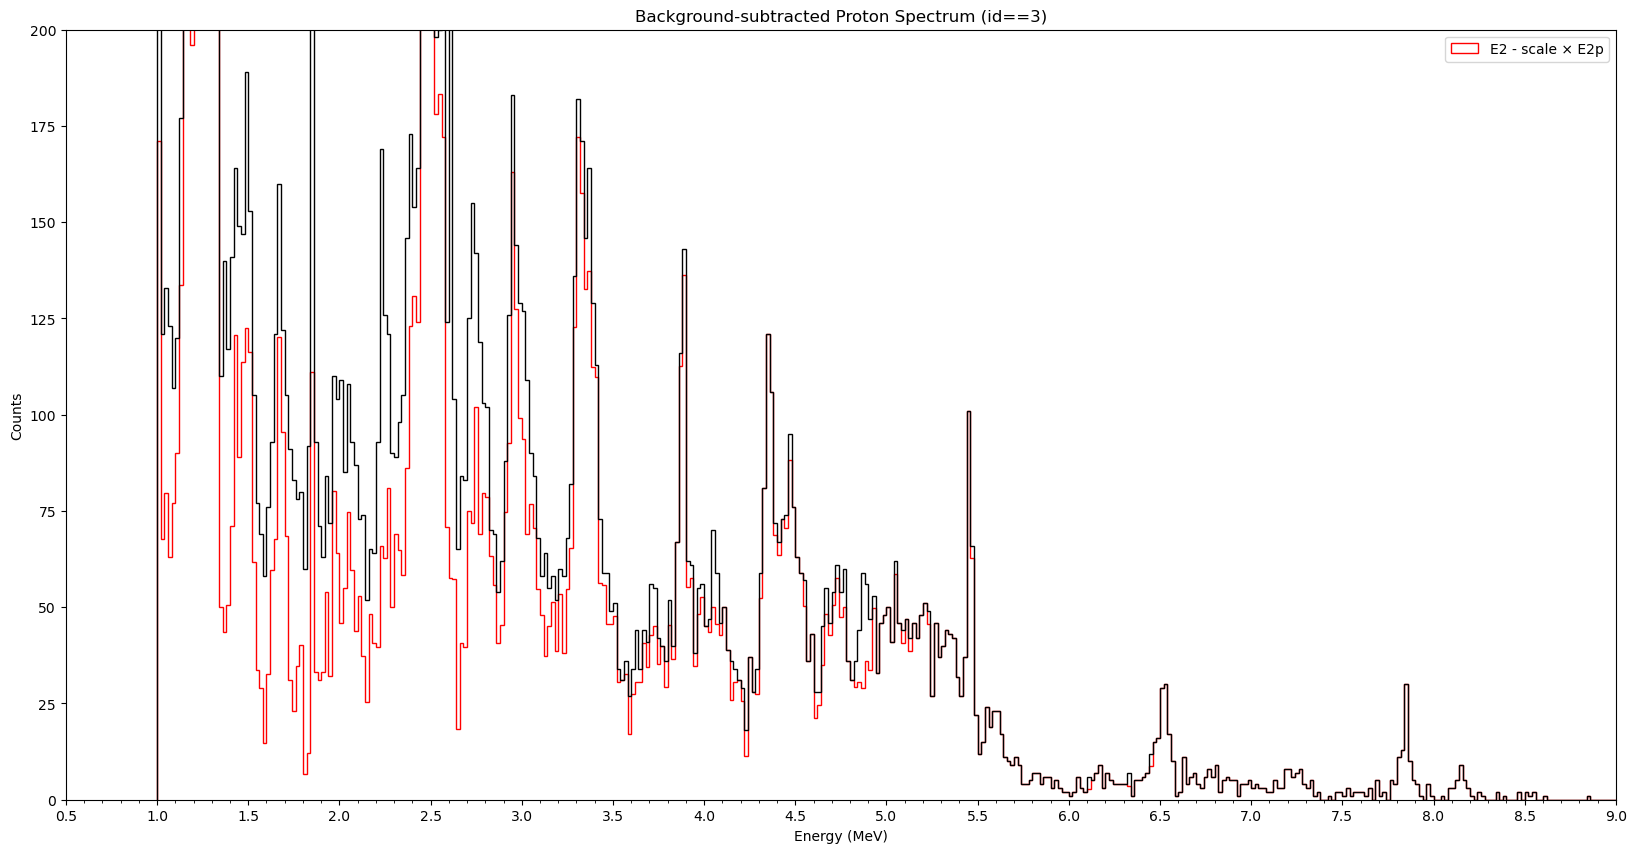

In [77]:
bins = np.arange(1, 9 + 0.01, 0.01)
counts_E2, _ = np.histogram(E2 / 1e3, bins=bins)

counts_E2p, _ = np.histogram(E2p / 1e3, bins=bins)
subtracted_counts = counts_E2 - scale * counts_E2p
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.figure(figsize=(20,10))
plt.hist(bins[:-1], bins=bins, weights=subtracted_counts, histtype='step',color='r', label='E2 - scale × E2p')
plt.hist(E2/1e3, bins=bins, histtype='step', color='k')#, weights=(res/np.max(sac4))*np.ones(len(E2)))
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.title('Background-subtracted Proton Spectrum (id==3)')
plt.legend()
plt.yscale('log')
plt.xlim(0.5,9)
#plt.ylim(0,200)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
plt.show()

bins = np.arange(1, 9 + 0.02, 0.02)
counts_E2, _ = np.histogram(E2 / 1e3, bins=bins)

counts_E2p, _ = np.histogram(E2p / 1e3, bins=bins)
subtracted_counts = counts_E2 - scale * counts_E2p
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.figure(figsize=(20,10))
plt.hist(bins[:-1], bins=bins, weights=subtracted_counts, histtype='step',color='r', label='E2 - scale × E2p')
plt.hist(E2/1e3, bins=bins, histtype='step', color='k')#, weights=(res/np.max(sac4))*np.ones(len(E2)))
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.title('Background-subtracted Proton Spectrum (id==3)')
plt.legend()
#plt.yscale('log')
plt.xlim(0.5,9)
plt.ylim(0,200)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
plt.show()

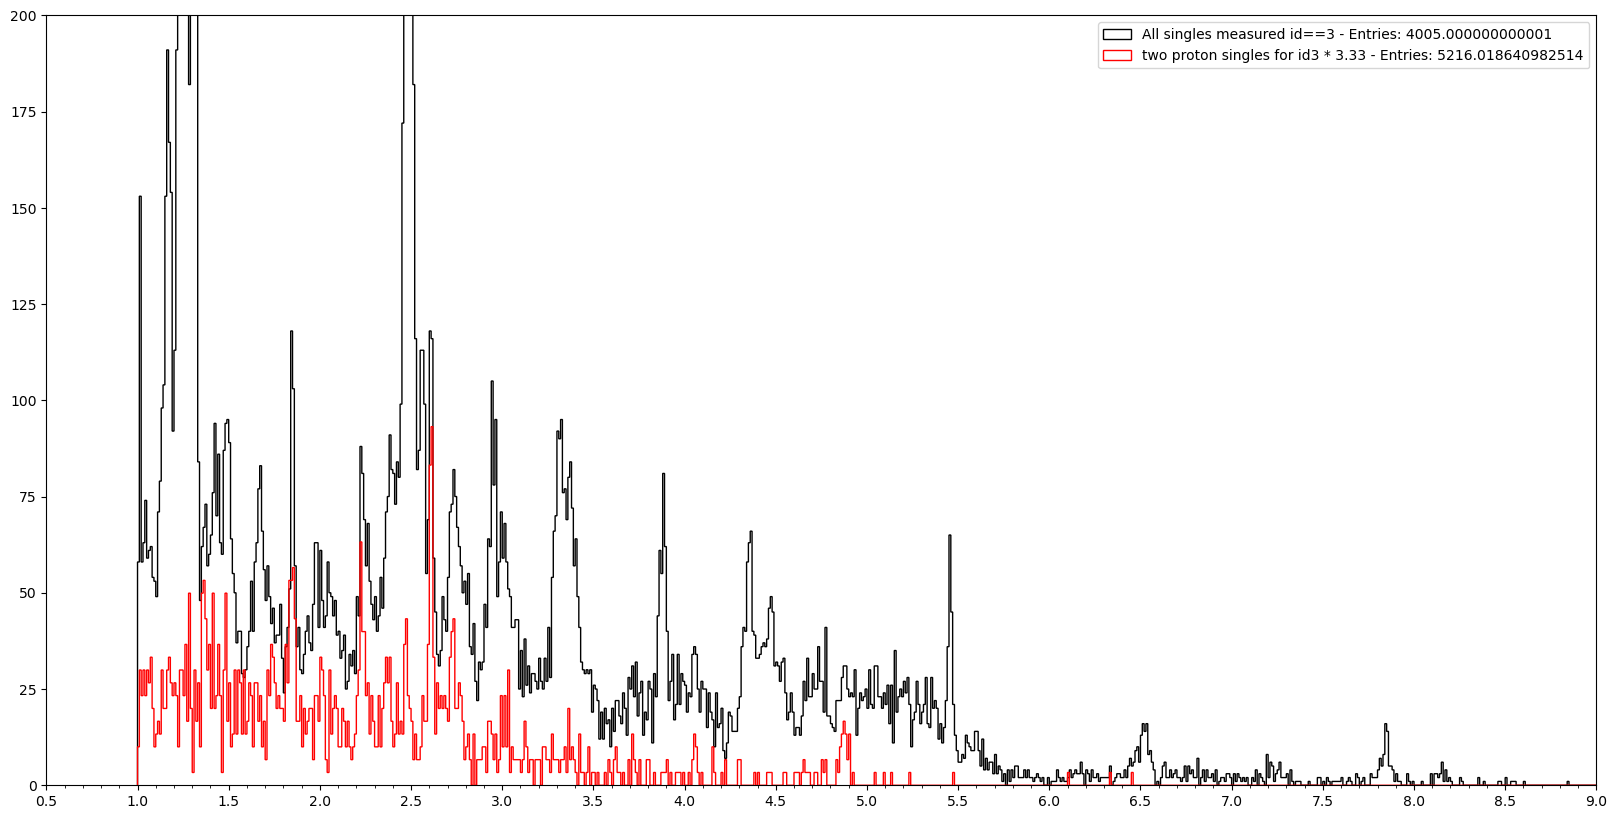

In [78]:
plt.figure(figsize=(20,10))
eees, ys = np.histogram(E2, bins=np.arange(1,9+0.01, 0.01))
plt.hist(E2/1e3, bins=np.arange(1,9+0.01, 0.01), histtype='step', color='k', label=f"All singles measured id==3 - Entries: {np.sum(ys)}")#, weights=(res/np.max(sac4))*np.ones(len(E2)))
plt.hist(E2p/1e3, bins=np.arange(1,9+0.01, 0.01), histtype='step', color='r', label=f"two proton singles for id3 * {scale:.2f} - Entries: {len(E2p)*scale}", weights=scale*np.ones(len(E2p)))
plt.yscale('linear')
plt.legend()
plt.xlim(0.5,9)
plt.ylim(0,200)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
plt.show()

In [79]:
EE = np.array([])
for batch in uproot.iterate(Al_files, expressions=["E"],
                            cut="(id==3)"):
    EE=np.append(EE, ak.flatten(batch.E))
    
EE2p = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E"]):
    EE2p=np.append(EE2p, ak.flatten(batch.E))


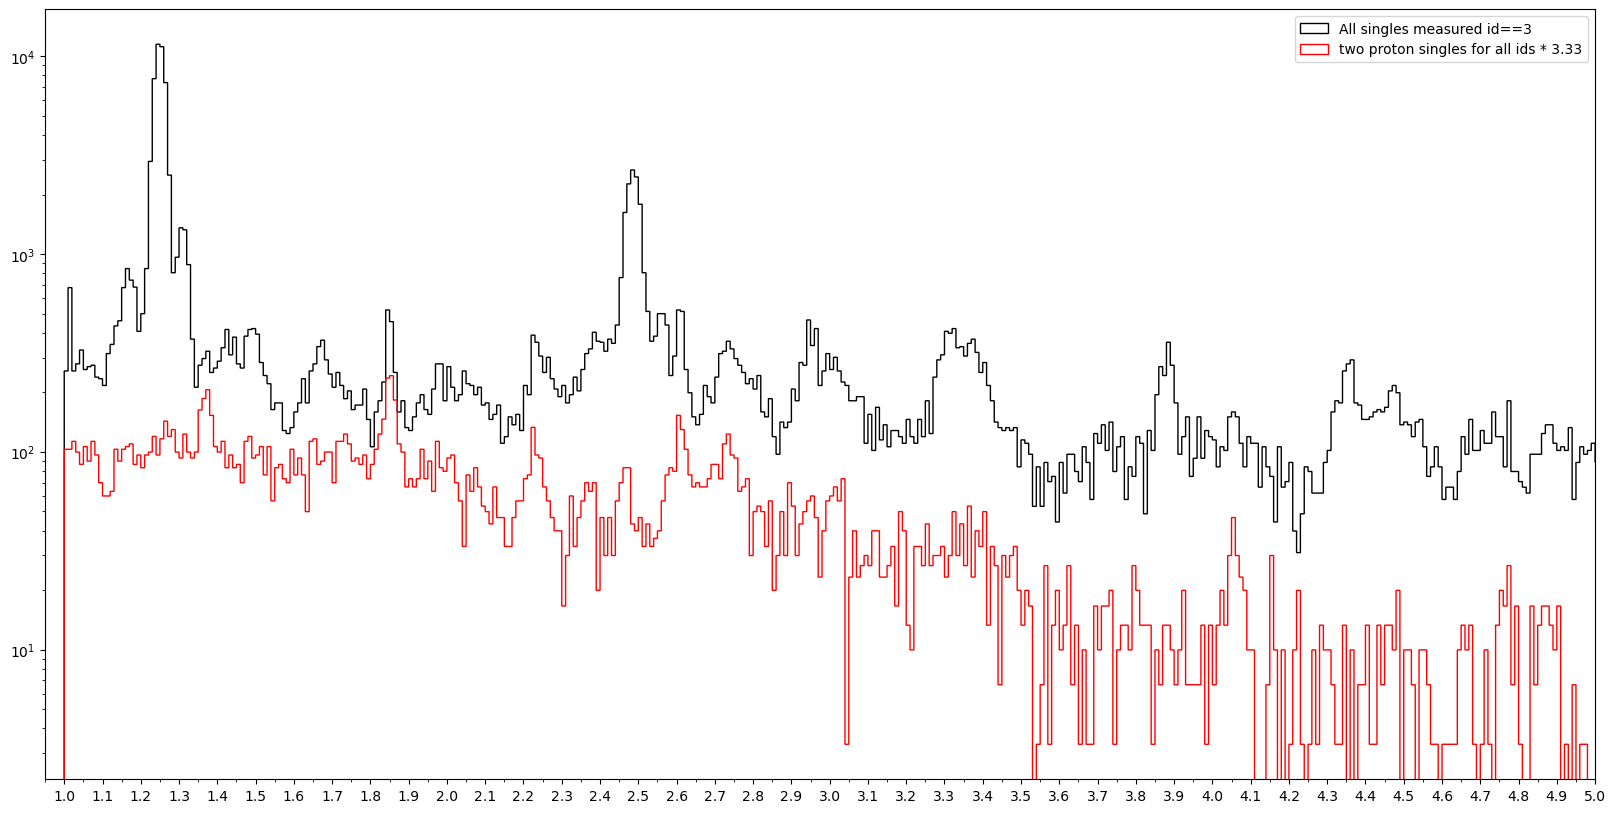

<Figure size 640x480 with 0 Axes>

In [85]:
plt.figure(figsize=(20,10))
plt.hist(EE/1e3, bins=np.arange(1,9+0.01, 0.01), histtype='step', color='k', label="All singles measured id==3", weights=(res/np.max(sac4))*np.ones(len(EE)))
plt.hist(EE2p/1e3, bins=np.arange(1,9+0.01, 0.01), histtype='step', color='r', label=f"two proton singles for all ids * {scale:.2f}", weights=scale*np.ones(len(EE2p)))
plt.yscale('log')
plt.legend()
plt.xlim(0.95,5)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
plt.show()
plt.savefig("2p.pdf")